<a href="https://colab.research.google.com/github/tteague19/xlab-security-course/blob/main/notebooks/02-cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carlini Wagner Attacks

In [9]:
# IF YOU ARE IN COLAB OR HAVE NOT INSTALLED `xlab-security`
!pip install xlab-security # should not take more than a minute or two to run
!pip install robustbench

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 894.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 480.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 419.5 kB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0
  Attempting uninstall: timm
    Found existing installation: timm 1.0.22
    Uninstalling timm-1.0.22:
      Successfully uninstalled timm-1.0.22


In [11]:
import xlab

# get CIFAR10 helper functions
from xlab.utils import CIFAR10
itos, stoi = CIFAR10.itos, CIFAR10.stoi

# for loading our model
from robustbench.utils import load_model

# pytorch imports
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

# for plotting
import matplotlib.pyplot as plt

device = xlab.utils.get_best_device()

In [12]:
# load our data
NUM_EXAMPLES = 100
x_test, y_test = xlab.utils.load_cifar10_test_samples(n=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

100%|██████████| 170M/170M [00:02<00:00, 62.6MB/s]


x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


We will begin by loading a pretrained model for classification on CIFAR using robustbench. If you are interested, the code to train the model can be found [here](https://github.com/zroe1/xlab-ai-security/tree/main/models/adversarial_basics_cnn).

In [13]:
from huggingface_hub import hf_hub_download
from xlab.models import MiniWideResNet, BasicBlock

# https://huggingface.co/uchicago-xlab-ai-security/tiny-wideresnet-cifar10
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/tiny-wideresnet-cifar10",
    filename="adversarial_basics_cnn.pth"
)
model = torch.load(model_path, map_location=device, weights_only=False)
_ = model.eval()

This is the same model that you were using in the previous notebook. As a refresher, you can see that the model has 165,722 trainable parameters, but image classifiers can get much larger.

In [15]:
# print the parameter count
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 165,722


## Tasks 1-5: Writing the function $f(x + \delta)$

Recall that we will be using a loss to minimize the equation below.
$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$

The function $\mathcal{D}$ measures how different $x$ (the original image) is from $x + \delta$ where $\delta$ is the perturbations we are making to the image. In the original paper, Carlini and Wagner list seven reasonable choices you could make for $f$. For brevity, you will only implement and compare 3 of them.

Note that the equations below are presented slightly differently than in the original paper. They are all mathematically equivalent, but we have rewritten some for clarity.

<details>
<summary>⚠️ <b>Caution</b></summary>

In this section we will have you implement 3 out of the 7 choices for $f$. We encourage you to implement the other choices of $f$ from [the paper](https://arxiv.org/pdf/1608.04644) if you are interested. We will caution you however that there appears to be a sign error in equation #1. The correct equation with the right signs should be shown below. Cross Entropy here will be taken with $\log_2$ rather than $\log_e$.

$$
f_1(x_{\mathrm{adversarial}}) = \mathrm{CrossEntropy}(F(x_{\mathrm{adversarial}})) - 1
$$

In general, we find that the "Objective Function" section of the paper has several mistakes. For example, they say that they "define an objective function $f$ such that $C(x + \delta) = t$ if and only if $f(x + \delta) \leq 0$." but it is trivial to show that equation 4 does not satisfy the "if and only if" condition.

</details>

### Task #1: Implementing $f_2$

For task #1 you will implement $f_2$ from [the paper](https://arxiv.org/pdf/1608.04644).

The equation for $f_2$ is below. $F_t(x)$ is the model output for class $t$ including the [softmax](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) which gives probabilities rather than logits. The first term in this equation takes the greatest softmax probability that is not the target class. We encourage you to pause and think about why the equation is structured in the way that it is.

$$
f_2(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(F(x_{\mathrm{adversarial}})) - F_t(x_{\mathrm{adversarial}})))
$$

<details>
<summary>🔐 <b>Solution for Task #1</b></summary>

```python
def f2(logits, target):
    """Computes the margin by which the highest non-target probability exceeds the target probability
    
    Args:
        logits [num_classes]: Raw prediction scores before softmax.
        target (int): Index of the true class.
        
    Returns:
        torch.Tensor: Scalar tensor representing the positive margin, zero if target has highest probability.
    """
    softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(softmax_probs)
    if i_neq_t == target:
        masked_probs = softmax_probs.clone()
        masked_probs[target] = float('-inf')
        i_neq_t = torch.argmax(masked_probs)
    return F.relu(softmax_probs[i_neq_t] - softmax_probs[target])
```
</details>

In [31]:
def f2(logits, target):
    """Computes the margin by which the highest non-target probability exceeds the target probability

    Args:
        logits [num_classes]: Raw prediction scores before softmax.
        target (int): Index of the true class.

    Returns:
        torch.Tensor: Scalar tensor representing the positive margin, zero if target has highest probability.
    """
    probs = F.softmax(logits, dim=0)
    target_prob = probs[target]
    max_nontarget_probs = torch.max(torch.cat([probs[0:target], probs[target+1:]]))
    return F.relu(max_nontarget_probs - target_prob)

In [32]:
x = torch.tensor([1.0, 3.0])
print(f2(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f2(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f2(x, 0)) # should be =0

tensor(0.7616)
tensor(0.)
tensor(0.)


In [33]:
_ = xlab.tests.cw.task1(f2)

============================= test session starts ==============================
collecting ... collected 30 items / 26 deselected / 4 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f2_output_shape_and_type PASSED [ 25%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f2_target_not_max PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f2_target_is_max PASSED [ 75%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f2_large_confidence_gap PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs:

### Task #2: Implementing $f_4$

This is similar to the equation above. The only difference is that we are enforcing the requirement that the target class has a probability greater than or equal to 0.5 rather than a probability greater than or equal to any of the other classes.

$$
f_4(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(0.5 - F_t(x_{\mathrm{adversarial}}))
$$

<details>
<summary>🔐 <b>Solution for Task #2</b></summary>

```python
def f4(logits, target):
    """Computes the deficit when target class probability falls below 50% confidence
    
    Args:
        logits [num_classes]: Raw prediction scores before softmax.
        target (int): Index of the true class.
        
    Returns:
        torch.Tensor: Scalar tensor representing the confidence deficit, zero if target probability >= 0.5.
    """
    softmax_probs = F.softmax(logits, dim=0)
    return F.relu(0.5 - softmax_probs[target])
```
</details>

In [36]:
def f4(logits, target):
    """Computes the deficit when target class probability falls below 50% confidence

    Args:
        logits [num_classes]: Raw prediction scores before softmax.
        target (int): Index of the true class.

    Returns:
        torch.Tensor: Scalar tensor representing the confidence deficit, zero if target probability >= 0.5.
    """
    probs = F.softmax(logits, dim=0)
    return F.relu(0.5 - probs[target])

In [37]:
x = torch.tensor([1.0, 3.0])
print(f4(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f4(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f4(x, 0)) # should be =0

tensor(0.3808)
tensor(0.)
tensor(0.)


In [38]:
_ = xlab.tests.cw.task2(f4)

============================= test session starts ==============================
collecting ... collected 30 items / 26 deselected / 4 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f4_output_shape_and_type PASSED [ 25%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f4_target_prob_above_threshold PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f4_target_prob_below_threshold PASSED [ 75%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f4_target_prob_near_threshold PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(

### Task #3: Implementing $f_6$

This is very similar to $f_2$. The difference is we use $Z_t(x)$ instead of $F_t(x)$. $Z_t(x)$ is the raw output of the model for class $t$ rather than the output after the softmax.

$$
f_6(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(Z(x_{\mathrm{adversarial}})) - Z_t(x_{\mathrm{adversarial}}))
$$

<details>
<summary>🔐 <b>Solution for Task #3</b></summary>

```python
def f6(logits, target):
    """Computes the margin by which the highest non-target logit exceeds the target logit
    
    Args:
        logits [num_classes]: Raw prediction scores before softmax.
        target (int): Index of the true class.
        
    Returns:
        torch.Tensor: Scalar tensor representing the positive logit margin, zero if target has highest logit.
    """
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        masked_logits = logits.clone()
        masked_logits[target] = float('-inf')
        i_neq_t = torch.argmax(masked_logits)
    return F.relu(logits[i_neq_t] - logits[target])
```

</details>

In [40]:
def f6(logits, target):
    """Computes the margin by which the highest non-target logit exceeds the target logit

    Args:
        logits [num_classes]: Raw prediction scores before softmax.
        target (int): Index of the true class.

    Returns:
        torch.Tensor: Scalar tensor representing the positive logit margin, zero if target has highest logit.
    """
    target_logit = logits[target]
    max_nontarget_logits = torch.max(torch.cat([logits[0:target], logits[target+1:]]))
    return F.relu(max_nontarget_logits - target_logit)

In [41]:
x = torch.tensor([1.0, 3.0])
print(f6(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f6(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f6(x, 0)) # should be =0

tensor(2.)
tensor(0.)
tensor(0.)


In [42]:
_ = xlab.tests.cw.task3(f6)

============================= test session starts ==============================
collecting ... collected 30 items / 25 deselected / 5 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f6_output_shape_and_type PASSED [ 20%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f6_target_not_max PASSED [ 40%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f6_target_is_max PASSED [ 60%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f6_large_logit_difference PASSED [ 80%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_f6_target_higher_than_max PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already 

By now you should have several options for $f$. Now we can optimize the equation below where we let $\mathcal{D}(x, x + \delta)$ be the $L_2$ norm.

$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$


We have implemented this below for you. The attack is extremely similar to the PGD attack you coded in the previous notebook, so it should look familiar to you. Still, you should read through the code and make sure you understand everything!

In [43]:
def cw_loss_v1(f, x, y, delta, c, model):
    logits = model(x + delta)
    f_loss = f(logits[0], y)
    norm_loss = (torch.sum(delta**2))**1/2

    return norm_loss + c * f_loss

def cw_simple(f, x, y, c, model, num_iters):
    delta = torch.randn_like(x) * 0.1
    delta.requires_grad = True
    optimizer = optim.Adam([delta], lr=1e-2)

    for i in range(num_iters):
        l = cw_loss_v1(f, x, y, delta, c, model)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 5 == 0:
            print(f"iteration {i + 1}:\t loss={l.item():.4f}")
    return torch.clip(x + delta, 0, 1)

### Task #4: Test different $f$ functions

The next step is to fill in the missing code below to test how effective different choices of $f$ are. When running `benchmark_f` for `f2`, `f4` and `f6` you should find that one choice of $f$ is much more effective than the other two.

<details>
<summary>💡 <b>Hint </b></summary>

$f_6$ Should have 100% attack success rate for the 5 images we selected. When we run our code we get:

* f2_results = [6, 1, 1, 1, 6]
* f4_results = [3, 1, 1, 0, 6]
* f6_results = [1, 1, 1, 1, 1]

</details>

<details>
<summary>🔐 <b>Solution for Task #4</b></summary>

```python
def benchmark_f(f, num_imgs=5, num_iters=40, target_class=1, c=1):
    """Benchmarks an adversarial attack function by running it on multiple test images
    
    Args:
        f (callable): Loss function to use in the Carlini-Wagner attack.
        num_imgs (int): Number of test images to attack.
        num_iters (int): Number of optimization iterations per attack.
        target_class (int): Target class index for the adversarial examples.
        c (float): Regularization parameter for the CW attack.
        
    Returns:
        list[int]: Predicted class indices for each generated adversarial example.
    """
    print(f"running attacks on {num_imgs} images with target='{itos[target_class]}'")

    results = []
    for i in range(num_imgs):
        x_clean = x_test[i:i+1].to(device) # tensor is [1, 3, 32, 32]
        
        adv_image = cw_simple(f, x_clean, target_class, c, model, num_iters) ### YOUR CODE HERE ###
        predicted_class = torch.argmax(model(adv_image)).item() ### YOUR CODE HERE ###
        print(f"model predicts class 'target='{itos[predicted_class]}'")
        results.append(predicted_class)

    return results
```

</details>

In [45]:
def benchmark_f(f, num_imgs=5, num_iters=40, target_class=1, c=1):
    """Benchmarks an adversarial attack function by running it on multiple test images

    Args:
        f (callable): Loss function to use in the Carlini-Wagner attack.
        num_imgs (int): Number of test images to attack.
        num_iters (int): Number of optimization iterations per attack.
        target_class (int): Target class index for the adversarial examples.
        c (float): Regularization parameter for the CW attack.

    Returns:
        list[int]: Predicted class indices for each generated adversarial example.
    """
    print(f"running attacks on {num_imgs} images with target='{itos[target_class]}'")

    results = []
    for i in range(num_imgs):
        x_clean = x_test[i:i+1].to(device) # tensor is [1, 3, 32, 32]

        adv_image = cw_simple(f=f, x=x_clean, y=target_class, c=c, model=model, num_iters=num_iters)
        predicted_class = model(adv_image).argmax().item()
        print(f"model predicts class 'target='{itos[predicted_class]}'")
        results.append(predicted_class)

    return results

In [46]:
f2_results = benchmark_f(f2)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=9.5622
iteration 10:	 loss=4.5457
iteration 15:	 loss=2.3324
iteration 20:	 loss=1.2586
iteration 25:	 loss=0.5777
iteration 30:	 loss=0.5045
iteration 35:	 loss=0.3345
iteration 40:	 loss=0.1836
model predicts class 'target='cat'
iteration 5:	 loss=8.9800
iteration 10:	 loss=3.4112
iteration 15:	 loss=1.5114
iteration 20:	 loss=0.7338
iteration 25:	 loss=0.6036
iteration 30:	 loss=0.7472
iteration 35:	 loss=0.6429
iteration 40:	 loss=0.4138
model predicts class 'target='automobile'
iteration 5:	 loss=9.4395
iteration 10:	 loss=4.6757
iteration 15:	 loss=2.7560
iteration 20:	 loss=1.5573
iteration 25:	 loss=1.6878
iteration 30:	 loss=1.5006
iteration 35:	 loss=1.3276
iteration 40:	 loss=1.1408
model predicts class 'target='ship'
iteration 5:	 loss=9.8500
iteration 10:	 loss=4.3425
iteration 15:	 loss=2.6750
iteration 20:	 loss=1.9351
iteration 25:	 loss=1.5093
iteration 30:	 loss=1.1324
iteration 35:	 loss=0.7845
i

In [47]:
f4_results = benchmark_f(f4)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=8.7517
iteration 10:	 loss=3.9625
iteration 15:	 loss=2.0137
iteration 20:	 loss=1.2667
iteration 25:	 loss=0.9484
iteration 30:	 loss=0.7821
iteration 35:	 loss=0.6818
iteration 40:	 loss=0.6152
model predicts class 'target='cat'
iteration 5:	 loss=8.1827
iteration 10:	 loss=3.5499
iteration 15:	 loss=1.6400
iteration 20:	 loss=1.0450
iteration 25:	 loss=0.6173
iteration 30:	 loss=0.3956
iteration 35:	 loss=0.5805
iteration 40:	 loss=0.5785
model predicts class 'target='automobile'
iteration 5:	 loss=8.2861
iteration 10:	 loss=3.6186
iteration 15:	 loss=1.7871
iteration 20:	 loss=0.7073
iteration 25:	 loss=0.6011
iteration 30:	 loss=0.6502
iteration 35:	 loss=0.4456
iteration 40:	 loss=0.2342
model predicts class 'target='automobile'
iteration 5:	 loss=7.8197
iteration 10:	 loss=3.3824
iteration 15:	 loss=1.2386
iteration 20:	 loss=0.7470
iteration 25:	 loss=0.7401
iteration 30:	 loss=0.5456
iteration 35:	 loss=0.

In [48]:
f6_results = benchmark_f(f6)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=13.7157
iteration 10:	 loss=11.1778
iteration 15:	 loss=8.2705
iteration 20:	 loss=5.7171
iteration 25:	 loss=3.7736
iteration 30:	 loss=2.4207
iteration 35:	 loss=1.5925
iteration 40:	 loss=1.5282
model predicts class 'target='automobile'
iteration 5:	 loss=12.2303
iteration 10:	 loss=7.7643
iteration 15:	 loss=4.5959
iteration 20:	 loss=2.6516
iteration 25:	 loss=1.5405
iteration 30:	 loss=1.3739
iteration 35:	 loss=1.5715
iteration 40:	 loss=1.5324
model predicts class 'target='automobile'
iteration 5:	 loss=13.6875
iteration 10:	 loss=10.3327
iteration 15:	 loss=7.0925
iteration 20:	 loss=4.5964
iteration 25:	 loss=2.9868
iteration 30:	 loss=2.1641
iteration 35:	 loss=1.7651
iteration 40:	 loss=1.5683
model predicts class 'target='automobile'
iteration 5:	 loss=12.1892
iteration 10:	 loss=7.9152
iteration 15:	 loss=4.7847
iteration 20:	 loss=2.8110
iteration 25:	 loss=1.7940
iteration 30:	 loss=1.5964
iteration

In [49]:
_ = xlab.tests.cw.task4(f2_results, f4_results, f6_results, 1)

============================= test session starts ==============================
collecting ... collected 30 items / 28 deselected / 2 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_arrays_have_equal_length PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_third_array_has_most_occurrences PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
================= 2 passed, 28 deselected, 2 warnings in 0.03s =================
✅ All checks passed!


## Task #5: choosing a value for $c$

In the previous section you should have seen that we picked a hardcoded value for $c$. But is there a better strategy than guessing? In the paper, the authors say:

<blockquote>
    Empirically, we have found that often the best way to choose $c$ is to use the smallest value of $c$ for which the resulting solution $x^{*}$ has $f(x^{*}) \leq 0$. This causes gradient descent to minimize both of the terms simultaneously instead of picking only one to optimize over first.
</blockquote>

In other words, to find the ideal result, we want our optimizer to make improvements that minimize the $f$ function but also have the minimum possible impact on the $L_p$ norm. If the $c$ value is too large, the $f$ function will dominate the loss and the optimizer may allow for a larger $L_p$ norm than is strictly necessary. If $c$ is too small, the attack won't be successful. By choosing the smallest possible $c$ that makes the attack successful, we get the best of both worlds.

In the code below you will benchmark different $c$ values for a small subset of CIFAR 10.

<details>
<summary>💡 <b>Hint for Task #5</b></summary>

A good starting point is to make sure that you are using the correct arguments to call `cw_simple`. From there, you should run your example back through the model to see if the attack was successful. In our code, we have:

```python
adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
predicted_class = torch.argmax(model(adv_image)).item()
```

</details>


<details>
<summary>🔐 <b>Solution for Task #5</b></summary>

```python
def benchmark_c_values(num_images, cw_iters, f, target_class):
    c_values = [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]
    c_values_to_prob = {c: 0 for c in c_values}
    c_values_to_l2_sum = {c: 0 for c in c_values}

    for c in c_values:
        ######### OPTIONAL: INIT VARIABLES HERE #########

        completed_attacks = 0
        img_idx = 0
        while completed_attacks < num_images:
            print(f"c = {c}: \tattack #{completed_attacks+1}")
            x_clean = x_test[img_idx:img_idx+1].to(device)
            img_idx += 1

            # we should not try to attack an image if the target label = the clean label
            if target_class == y_test[img_idx:img_idx+1].item():
                continue

            ######### YOUR CODE STARTS HERE #########
            # 1. find adversarial image using cw_simple, with arguments cw_iters & f   
            adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
            
            # 2. check if cw attack was successful & update c_values_to_prob
            predicted_class = torch.argmax(model(adv_image)).item()
            if predicted_class == target_class:
                c_values_to_prob[c] += 1
            
            # 3. calculate l2 norm (use distance func) & update c_values_to_l2_sum
            c_values_to_l2_sum[c] += distance(adv_image, x_clean, 2).item()
            ######### YOUR CODE ENDS HERE #########
            
            completed_attacks += 1

    ######### OPTIONAL: FINAL PROCESSING HERE #########
    for c,l2_sum in c_values_to_l2_sum.items():
        c_values_to_l2_sum[c] = l2_sum/num_images
    for c,succ_count in c_values_to_prob.items():
        c_values_to_prob[c] = succ_count/num_images
    return c_values_to_l2_sum, c_values_to_prob
```
</details>

In [50]:
def distance(x1, x2, p):
    return torch.sum(torch.abs(x1 -x2)**p) ** (1/p)

In [66]:
def benchmark_c_values(num_images, cw_iters, f, target_class):
    c_values = [1e-3, 1e-2, 1.5e-2, 1e-1, 1e1, 1e2, 1e3]
    c_values_to_prob = {c: 0 for c in c_values}
    c_values_to_l2_sum = {c: 0 for c in c_values}

    for c in c_values:
        ######### OPTIONAL: INIT VARIABLES HERE #########

        completed_attacks = 0
        img_idx = 0
        while completed_attacks < num_images:
            print(f"c = {c}: \tattack #{completed_attacks+1}")
            x_clean = x_test[img_idx:img_idx+1].to(device)
            img_idx += 1

            # we should not try to attack an image if the target label = the clean label
            if target_class == y_test[img_idx:img_idx+1].item():
                continue

            ######### YOUR CODE STARTS HERE #########
            # 1. find adversarial image using cw_simple, with arguments cw_iters & f
            x_adv = cw_simple(
              f=f,
              x=x_clean,
              y=target_class,
              c=c,
              model=model,
              num_iters=cw_iters,
            )

            # 2. check if cw attack was successful & update c_values_to_prob
            predicted_class = torch.argmax(model(x_adv)).item()
            if predicted_class == target_class:
                c_values_to_prob[c] += 1

            # 3. calculate l2 norm (use distance func) & update c_values_to_l2_sum
            c_values_to_l2_sum[c] += distance(x_adv, x_clean, 2).item()

            ######### YOUR CODE ENDS HERE #########

            completed_attacks += 1

    ######### OPTIONAL: FINAL PROCESSING HERE #########

    for c, l2_sum in c_values_to_l2_sum.items():
        c_values_to_l2_sum[c] = l2_sum / num_images
    for c, succ_count in c_values_to_prob.items():
        c_values_to_prob[c] = succ_count / num_images
    return c_values_to_l2_sum, c_values_to_prob

In [67]:
c_values_to_l2_sum, c_values_to_prob = benchmark_c_values(5, 15, f6, 1)

c = 0.001: 	attack #1
iteration 5:	 loss=8.1469
iteration 10:	 loss=3.3960
iteration 15:	 loss=1.4218
c = 0.001: 	attack #2
iteration 5:	 loss=7.9260
iteration 10:	 loss=3.1989
iteration 15:	 loss=1.3171
c = 0.001: 	attack #3
iteration 5:	 loss=8.0990
iteration 10:	 loss=3.3393
iteration 15:	 loss=1.4345
c = 0.001: 	attack #4
iteration 5:	 loss=8.2449
iteration 10:	 loss=3.3404
iteration 15:	 loss=1.3761
c = 0.001: 	attack #5
iteration 5:	 loss=7.7970
iteration 10:	 loss=3.1826
iteration 15:	 loss=1.3625
c = 0.01: 	attack #1
iteration 5:	 loss=7.7910
iteration 10:	 loss=3.1533
iteration 15:	 loss=1.3430
c = 0.01: 	attack #2
iteration 5:	 loss=7.7795
iteration 10:	 loss=3.1213
iteration 15:	 loss=1.3262
c = 0.01: 	attack #3
iteration 5:	 loss=7.7132
iteration 10:	 loss=3.1018
iteration 15:	 loss=1.3194
c = 0.01: 	attack #4
iteration 5:	 loss=7.6743
iteration 10:	 loss=3.0642
iteration 15:	 loss=1.2845
c = 0.01: 	attack #5
iteration 5:	 loss=8.1556
iteration 10:	 loss=3.3968
iteration 15

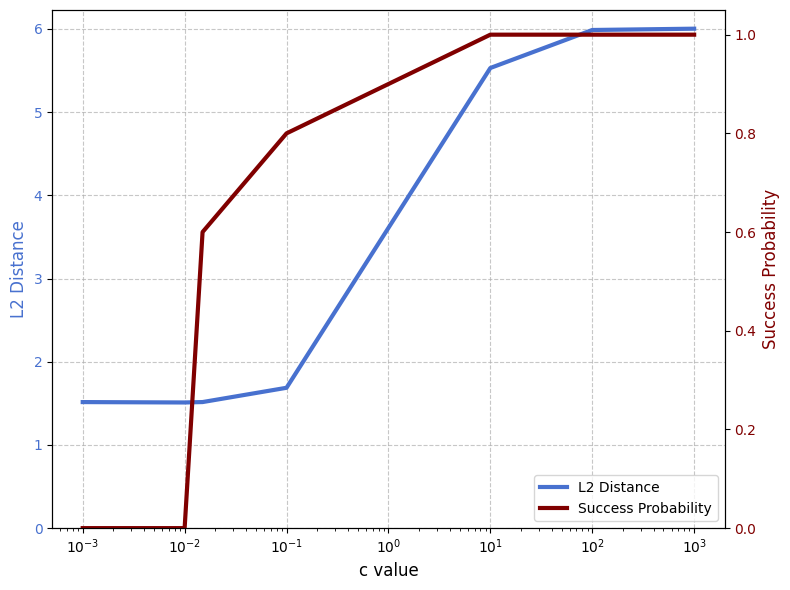

In [68]:
fig, ax1, ax2 = xlab.utils.plot_dual_2d(
    x=list(c_values_to_l2_sum.keys()),
    y1=list(c_values_to_l2_sum.values()),
    y2=list(c_values_to_prob.values()),
    y1_label='L2 Distance',
    y2_label='Success Probability',
    x_label='c value',
    y1_axis_label='L2 Distance',
    y2_axis_label='Success Probability',
    log_x=True,
)

### What do these results mean?

This shows that there is some tradeoff between $L_2$ distance and the probability of attack success. Perhaps an even better way to think about this is that there is a tradeoff between how close an image is to its original and how easily one can fool the model.


Recall that the authors claim that one should choose the smallest value of $c$ that still results in a successful attack. In the paper, the authors use a modified binary search to find this value of $c$. For brevity, we leave this as an exercise to the reader but would not expect this to be too difficult to program. For our purposes, we observe that given a reasonable number of iterations in the $L_2$ setting, $c=0.015$ gives a high probability of success and undetectable perturbations.

## Task #6: Confidence-Adjusted $f$

In task 4, you found that $f_6$ was the most effective choice for $f$. For the $L_2$ attack that we will be implementing, the authors use a slight variation of $f_6$ which introduces a new constant $\tau$ which encourages the attack to find classifications that confidently choose the wrong class. This variation is shown below:

$$
f_6(x_{\mathrm{adversarial}}) = \max((\max_{i \neq t}(Z(x_{\mathrm{adversarial}}) - Z_t(x_{\mathrm{adversarial}})), -\tau)
$$

The $\tau$ parameter is different than the $c$ parameter. While the $c$ parameter weights how much the attack cares about the function $f$, the $\tau$ parameter determines a threshold for how confident of a misclassification $f$ is aiming for.

<details>
<summary>🔐 <b>Solution for Task #6</b></summary>

```python
def confident_f6(logits, target, tau):
    """Computes the logit margin between highest non-target and target class, clamped to minimum of -tau
    
    Args:
        logits [num_classes]: Raw prediction scores before softmax.
        target (int): Index of the true class.
        tau (float): Minimum threshold for the negative margin.
        
    Returns:
        torch.Tensor: Scalar tensor representing the logit margin, bounded below by -tau.
    """
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        masked_logits = logits.clone()
        masked_logits[target] = float('-inf')
        i_neq_t = torch.argmax(masked_logits)
    return torch.max((logits[i_neq_t] - logits[target]), -torch.tensor(tau))
```

</details>

In [75]:
def confident_f6(logits, target, tau):
    """Computes the logit margin between highest non-target and target class, clamped to minimum of -tau

    Args:
        logits [num_classes]: Raw prediction scores before softmax.
        target (int): Index of the true class.
        tau (float): Minimum threshold for the negative margin.

    Returns:
        torch.Tensor: Scalar tensor representing the logit margin, bounded below by -tau.
    """

    target_logit = logits[target]
    max_nontarget_logits = torch.max(
        torch.cat([logits[0:target], logits[target+1:]])
    )
    return torch.max(
      torch.max(max_nontarget_logits - target_logit, -torch.tensor(tau))
    )

In [76]:
tau = 0.01

x = torch.tensor([1.0, 3.0])
print(confident_f6(x, 0, tau)) # should be >0
x = torch.tensor([1.0, 1.0])
print(confident_f6(x, 0, tau)) # should be =0
x = torch.tensor([3.0, 1.0])
print(confident_f6(x, 0, tau)) # should be <0

tensor(2.)
tensor(0.)
tensor(-0.0100)


In [77]:
_ = xlab.tests.cw.task6(confident_f6)

============================= test session starts ==============================
collecting ... collected 30 items / 24 deselected / 6 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_confident_f6_output_shape_and_type PASSED [ 16%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_confident_f6_target_not_max PASSED [ 33%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_confident_f6_target_is_max PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_confident_f6_tau_clamping PASSED [ 66%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_confident_f6_no_clamping_needed PASSED [ 83%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_confident_f6_different_tau_values PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_

## Task 7-8: Change of variables

If you have not already read [our writeup for Carlini-Wagner attacks](https://xlabaisecurity.com/adversarial/cw/) on our website, we highly recommend you do so now. Here is where things start to get tricky.

So far we have been thinking about adversarial examples as $x$ (the original image) plus a set of perturbations $\delta$ bounded by some $L_p$ norm. The issue is that $x + \delta$ can be greater than 1 or less than 0, which would make it an invalid image. Therefore, Carlini and Wagner propose writing $x + \delta$ as a function of a new variable $w$ where $f(w)$ is always between zero and one. Here is the equation they proposed:

$$
x_i + \delta_i = \frac{1}{2} (\tanh({w_i}) + 1)
$$

### Task #7: Calculate $x + \delta$ given $w$

In task #7, you will calculate the above equation element-wise to find tensor $x + \delta$ given a tensor $w$.

<details>
<summary>🔐 <b>Solution for Task #7</b></summary>

```python
def get_adv_from_w(w):
    """Converts unconstrained parameter tensor to valid adversarial example in [0,1] range
    
    Args:
        w [*]: Unconstrained parameter tensor of arbitrary shape.
        
    Returns:
        torch.Tensor: Tensor with same shape as w, values mapped to [0,1] range.
    """
    return 0.5 * (torch.tanh(w) + 1)```

</details>

In [78]:
def get_adv_from_w(w):
    """Converts unconstrained parameter tensor to valid adversarial example in [0,1] range

    Args:
        w [*]: Unconstrained parameter tensor of arbitrary shape.

    Returns:
        torch.Tensor: Tensor with same shape as w, values mapped to [0,1] range.
    """
    return 0.5 * (torch.tanh(w) + 1)

In [79]:
_ = xlab.tests.cw.task7(get_adv_from_w)

============================= test session starts ==============================
collecting ... collected 30 items / 26 deselected / 4 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_get_adv_from_w_output_shape_and_type PASSED [ 25%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_get_adv_from_w_value_range PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_get_adv_from_w_specific_values PASSED [ 75%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_get_adv_from_w_gradient_preservation PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugi

### Task #8: Calculate $x + \delta$ given $w$

In task #8, you will find the tensor for $\delta$: i.e., the difference between $x$ and the adversarial image.


<details>
<summary>🔐 <b>Solution for Task #7</b></summary>

```python
def get_delta(w, x):
    """Computes the perturbation between adversarial example and original input
    
    Args:
        w [*]: Unconstrained parameter tensor of arbitrary shape.
        x [*]: Original input tensor with same shape as w.
        
    Returns:
        torch.Tensor: Perturbation tensor representing the difference between adversarial and original input.
    """
    return 0.5 * (torch.tanh(w) + 1) - x
```

</details>

In [80]:
def get_delta(w, x):
    """Computes the perturbation between adversarial example and original input

    Args:
        w [*]: Unconstrained parameter tensor of arbitrary shape.
        x [*]: Original input tensor with same shape as w.

    Returns:
        torch.Tensor: Perturbation tensor representing the difference between adversarial and original input.
    """
    return 0.5 * (torch.tanh(w) + 1) - x

In [81]:
_ = xlab.tests.cw.task8(get_delta)

============================= test session starts ==============================
collecting ... collected 30 items / 25 deselected / 5 selected

../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_get_delta_output_shape_and_type PASSED [ 20%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_get_delta_computation PASSED [ 40%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_get_delta_zero_case PASSED [ 60%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_get_delta_gradient_preservation PASSED [ 80%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/cw.py::test_get_delta_different_shapes PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWar

Now, let's plot what we have found. If we randomly initialize $w$ we should see large values for delta which are both positive and negative. However, $x+\delta$ should be between 0 and 1. <b>You should not expect to see a reasonable adversarial image if you randomly initialize $w$.</b>

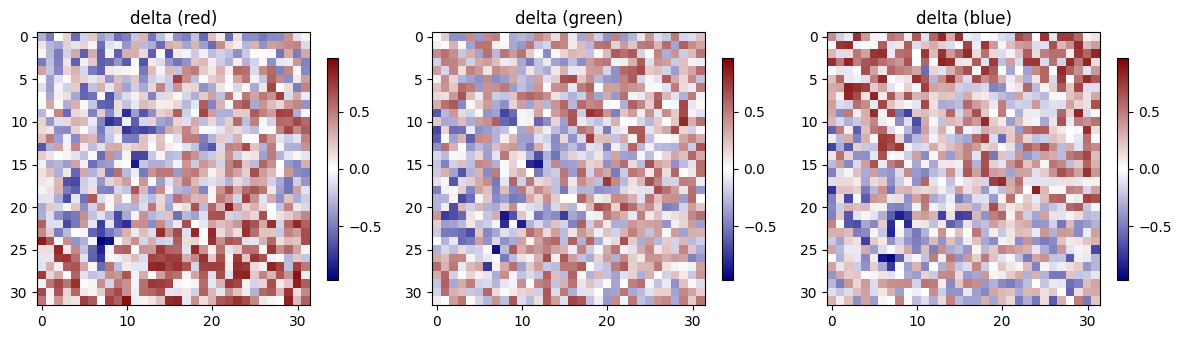

In [82]:
x_clean = x_test[0:0+1]
rand_w = torch.randn_like(x_clean)
adv = get_adv_from_w(rand_w)[0].cpu()
delta = get_delta(rand_w, x_clean)[0].cpu()

# you should expect to see positive and negative numbers
_ = xlab.utils.plot_tensors(
    [delta[0], delta[1], delta[2]],
    log_scale=False,
    ncols=3,
    # log_scale=True,
    titles = ["delta (red)", "delta (green)", "delta (blue)"]
)

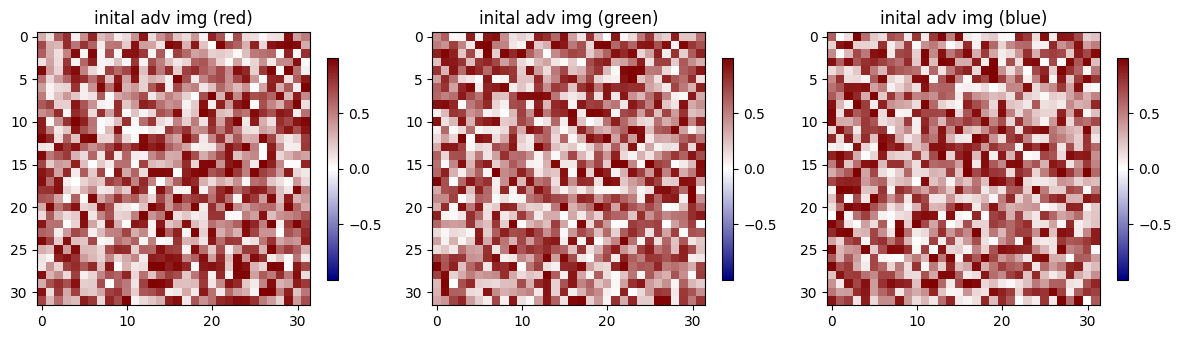

In [83]:
# you should expect to see plots of positive numbers between 0 and 1
_ = xlab.utils.plot_tensors(
    [adv[0], adv[1], adv[2]],
    log_scale=False,
    ncols=3,
    # log_scale=True,
    titles = ["inital adv img (red)", "inital adv img (green)", "inital adv img (blue)"]
)

## Task #9: Putting it all together

Recall the following equation from [the webpage](https://xlabaisecurity.com/adversarial/cw/) associated with these exercises. This outlines the structure of the loss that the CW attack aims to minimize.

$$
\mathrm{minimize} \ \   \| \delta \|_p + c \cdot f(x + \delta)
$$

With the change of variable shown above, this becomes:

$$
\mathrm{minimize} \ \   \| \frac{1}{2} (\tanh({w}) + 1) - x \|_p + c \cdot f(\frac{1}{2} (\tanh({w}) + 1))
$$

Now we will use this equation to implement the $L_2$ Carlini-Wagner attack the way that the authors constructed it in the original paper. There are two details that require your attention before continuing:

1. The authors use $\| \delta \|_2^2$ rather than $\| \delta \|_2$ to minimize the size of $\delta$.
2. The authors choose $f$ to be the function you implemented in `confident_f6` rather than the function you implemented in `f6`

This means your loss should look like this:

$$
\mathrm{minimize} \ \   \| \frac{1}{2} (\tanh({w}) + 1) - x \|_2^2 + c \cdot f_{\mathrm{6-confident}}(\frac{1}{2} (\tanh({w}) + 1))
$$

<details>
<summary>Hint for Task #9</summary>

The image for this function will be passed with a batch dimension because that is what the model expects. However, when you call `confident_f6` the logits for a single image are expected. Therefore, you should squeeze out the zeroth dimension, as shown below.

```python
success_loss = c * confident_f6(logits[0], target, k)
```
</details>

<details>
<summary>🔐 <b>Solution for Task #9</b></summary>

```python
def CW_targeted_l2(img, model, c, target, k=0.1, l2_limit=0.5, num_iters=50):
    device = next(model.parameters()).device
    print(f"Using device: {device} for testing...")

    # initialize cw weights and optimizer
    cw_weights = torch.randn_like(img).to(device) * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    delta = get_delta(cw_weights, img)

    for _ in range(num_iters):
        # 1. Find logits
        logits = model(img + delta)

        # 2. Use c and confident_f6 to calculate the loss
        success_loss = c * confident_f6(logits[0], target, k)

        # 3. Find the L2 loss
        l2_reg = torch.sum((delta) ** 2)

        # 4. Call loss.backward(), optimizer.step(), optimizer.zero_grad()
        loss = success_loss + l2_reg
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        delta = get_delta(cw_weights, img)

    # print results of attack
    with torch.no_grad():
        print(f"total L2 loss:\t {torch.sum((delta) ** 2)}")
        
        logits = model(img + delta)
        if torch.argmax(logits[0]) == target:
            print(f"Attack was successful: classification={target}")
        else:
            print(f"Attack was not successful: classification={torch.argmax(logits[0])}")
    
    return get_adv_from_w(cw_weights)


```
</details>


In [100]:
def CW_targeted_l2(img, model, c, target, k=0.1, l2_limit=0.5, num_iters=50):
    device = next(model.parameters()).device
    print(f"Using device: {device} for testing...")

    # initialize cw weights and optimizer
    cw_weights = torch.randn_like(img).to(device) * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    delta = get_delta(cw_weights, img)

    for _ in range(num_iters):

        ######### YOUR CODE STARTS HERE #########
        # 1. Find logits
        logits = model(img + delta)

        # 2. Use c and confident_f6 to calculate the loss
        loss = c * confident_f6(logits=logits[0], target=target, tau=k)

        # 3. Find the L2 loss
        l2_reg = torch.sum((delta) ** 2)
        if l2_reg > l2_limit:
            l2_reg = torch.relu(l2_reg - l2_limit)
        loss += l2_reg

        # 4. Call loss.backward(), optimizer.step(), optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ######### YOUR CODE ENDS HERE #########

        delta = get_delta(cw_weights, img)

    # print results of attack
    with torch.no_grad():
        print(f"total L2 loss:\t {torch.sum((delta) ** 2)}")

        logits = model(img + delta)
        if torch.argmax(logits[0]) == target:
            print(f"Attack was successful: classification={target}")
        else:
            print(f"Attack was not successful: classification={torch.argmax(logits[0])}")

    return get_adv_from_w(cw_weights)


There are no automated tests for this final function but if you are able to misclassify the image of a cat using the code below, your solution is probably correct. We encourage you to also test on other images in the CIFAR-10 dataset.

In [111]:
img_adv = CW_targeted_l2(x_test[0:1], model, 0.015, 2, k=0.1, l2_limit=0.5, num_iters=50)

Using device: cpu for testing...
total L2 loss:	 0.3856082260608673
Attack was successful: classification=2


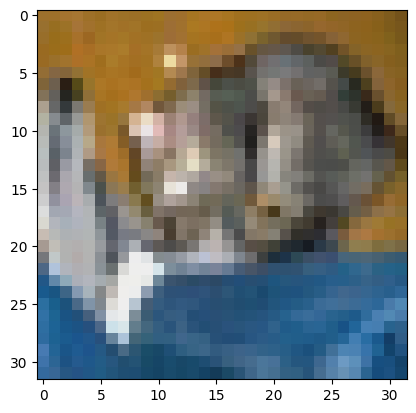

In [112]:
xlab.utils.show_image(img_adv.cpu())

## Further Exploration

Congratulations on finishing this notebook! The Carlini-Wagner attack is influential and well-designed, but is also much more difficult than the content you encountered in the previous section.

If you are interested in exploring this attack further, there are a few aspects of the original paper that we did not cover which you may find informative:

1. For the $L_2$ attack, the authors use multiple starting points for their gradient descent to reduce the likelihood that the optimization becomes stuck in a local minimum. Implementation details for this can be found on page 9 of [the paper](https://arxiv.org/pdf/1608.04644).
2. The paper also includes implementation details for two other types of CW attacks: the $L_0$ and $L_\infty$ attacks. Now that you have completed the $L_2$ attack, the $L_\infty$ should not be too difficult, as it is quite similar.
3. Try benchmarking FGSM, PGD, and CW on different datasets. You should find that each attack has its own advantages and disadvantages. CW, for example, may be more effective against some defenses, while FGSM attacks should have a higher likelihood of transferring to an entirely different model.